# Capstone Project Part 06: EDA and Cleaning

## Import libraries and modules

In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

/Users/junkai/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Load scraped data

Load `edgar_sp500.csv` and `edgar_sp1000.csv` from `data` folder into a pandas DataFrame.

In [2]:
edgar_sp500 = pd.read_csv('../data/edgar_sp500.csv')
edgar_sp500.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11241933 entries, 0 to 11241932
Data columns (total 5 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   security     object
 1   name         object
 2   value        object
 3   unit_ref     object
 4   context_ref  object
dtypes: object(5)
memory usage: 428.8+ MB


In [3]:
edgar_sp1000 = pd.read_csv('../data/edgar_1000.csv')
edgar_sp1000.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6569223 entries, 0 to 6569222
Data columns (total 5 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   security     object
 1   name         object
 2   value        object
 3   unit_ref     object
 4   context_ref  object
dtypes: object(5)
memory usage: 250.6+ MB


In [4]:
df = pd.concat((edgar_sp500, edgar_sp1000)).reset_index(drop=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17811156 entries, 0 to 17811155
Data columns (total 5 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   security     object
 1   name         object
 2   value        object
 3   unit_ref     object
 4   context_ref  object
dtypes: object(5)
memory usage: 679.4+ MB


---

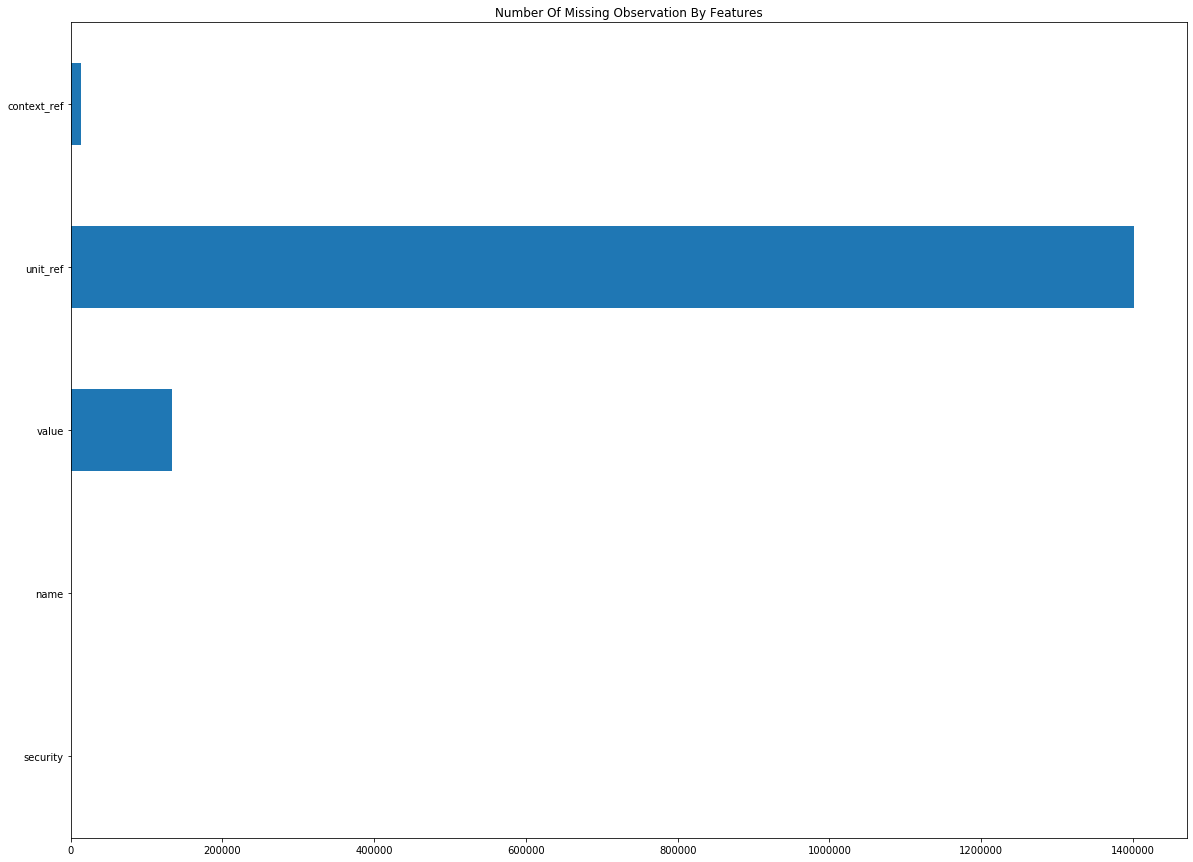

In [6]:
df.isnull().sum().plot.barh(
    figsize=(20, 15), 
    title='Number Of Missing Observation By Features'
);

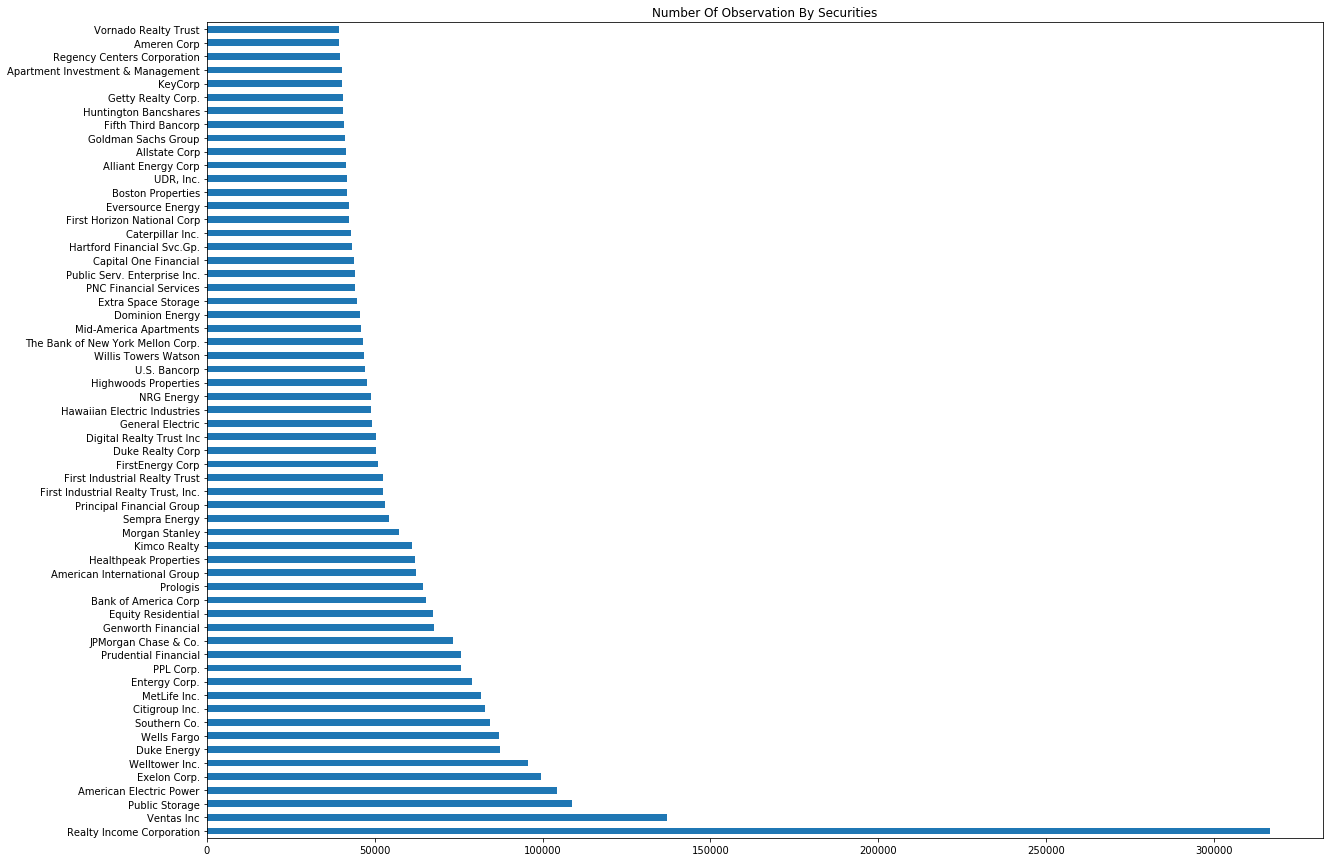

In [7]:
df['security'].value_counts()[:60].plot.barh(
    figsize=(20, 15), 
    title='Number Of Observation By Securities'
);

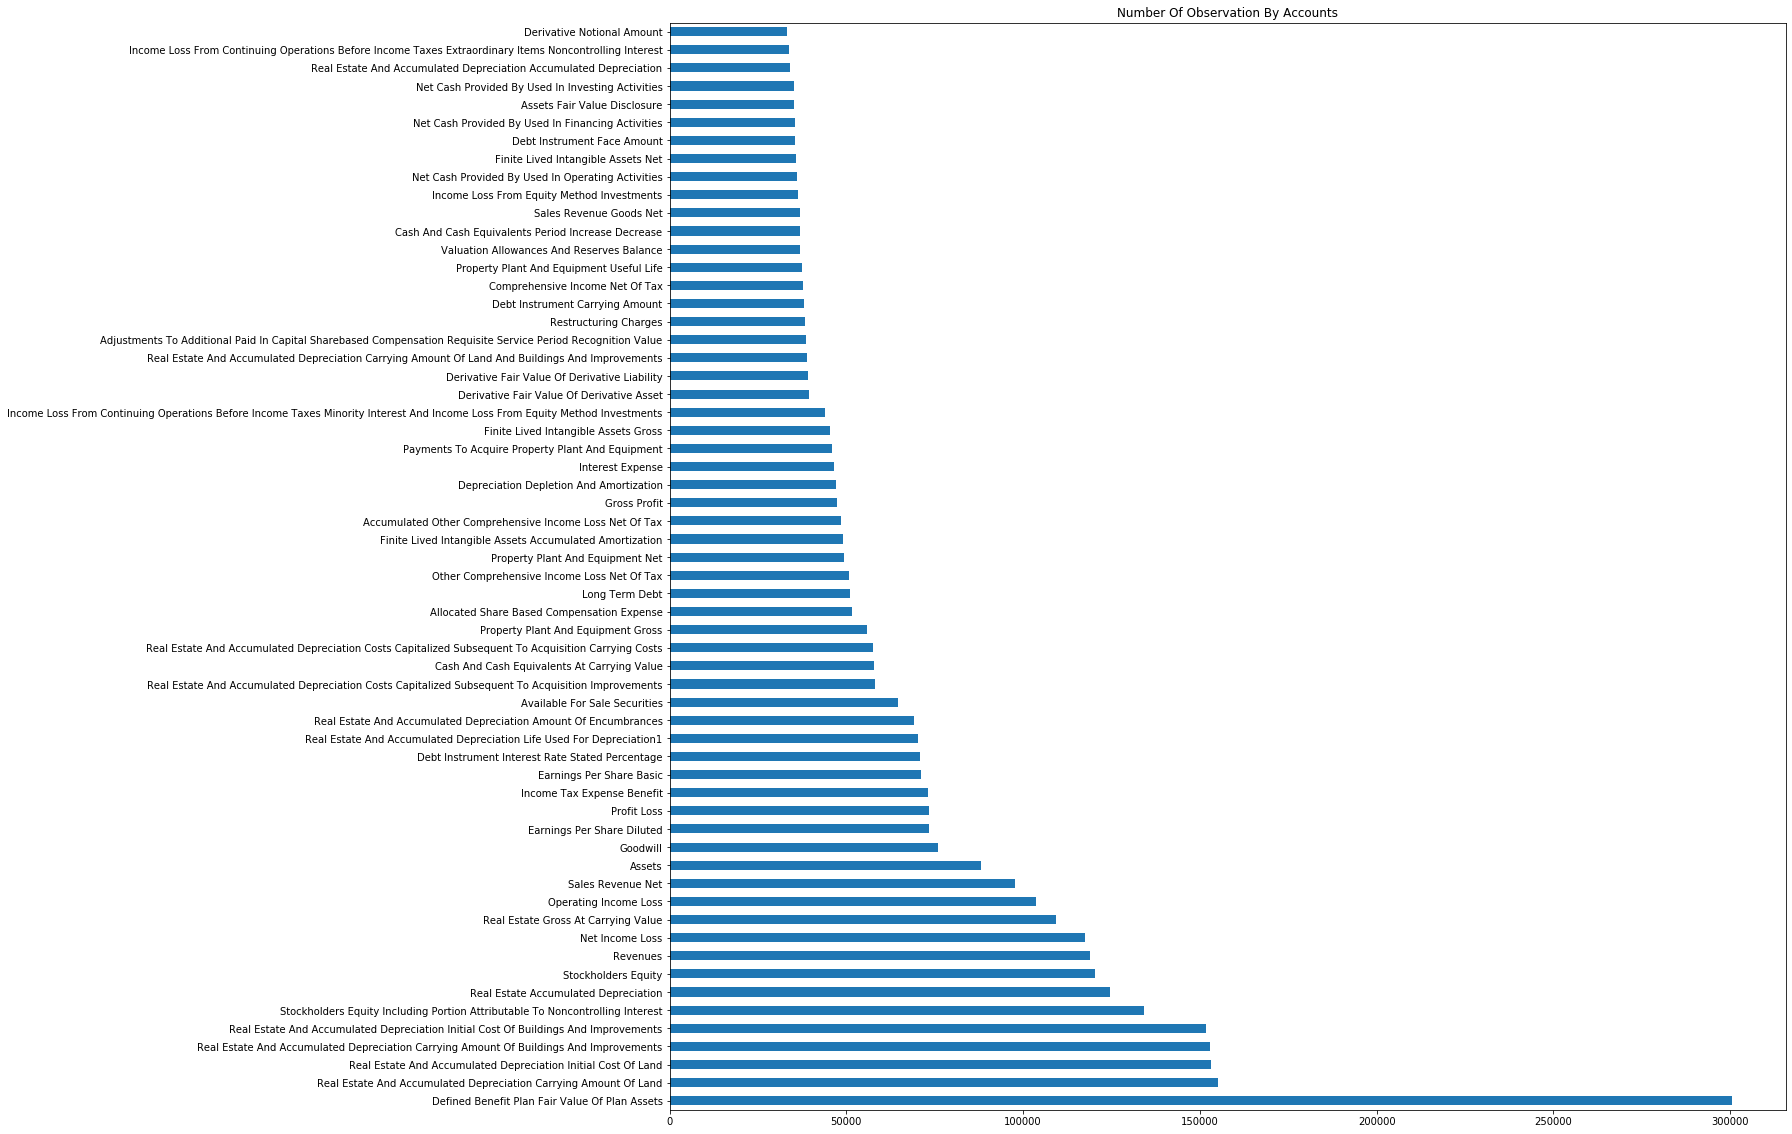

In [8]:
df['name'].value_counts()[:60].plot.barh(
    figsize=(20, 20),
    title='Number Of Observation By Accounts'
);

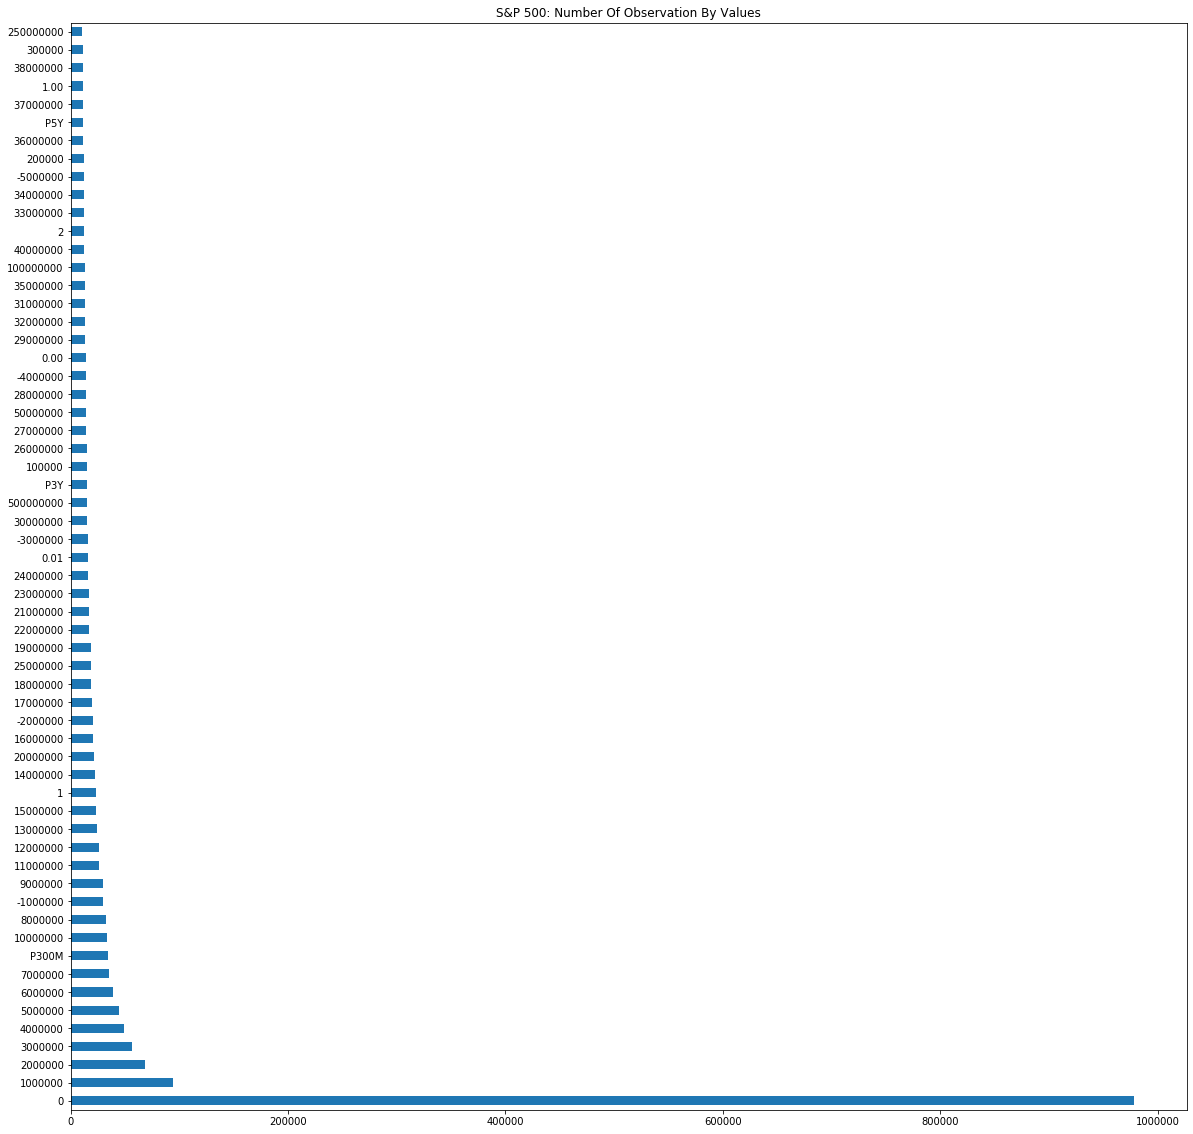

In [9]:
edgar_sp500['value'].value_counts()[:60].plot.barh(
    figsize=(20, 20),
    title='S&P 500: Number Of Observation By Values'
);

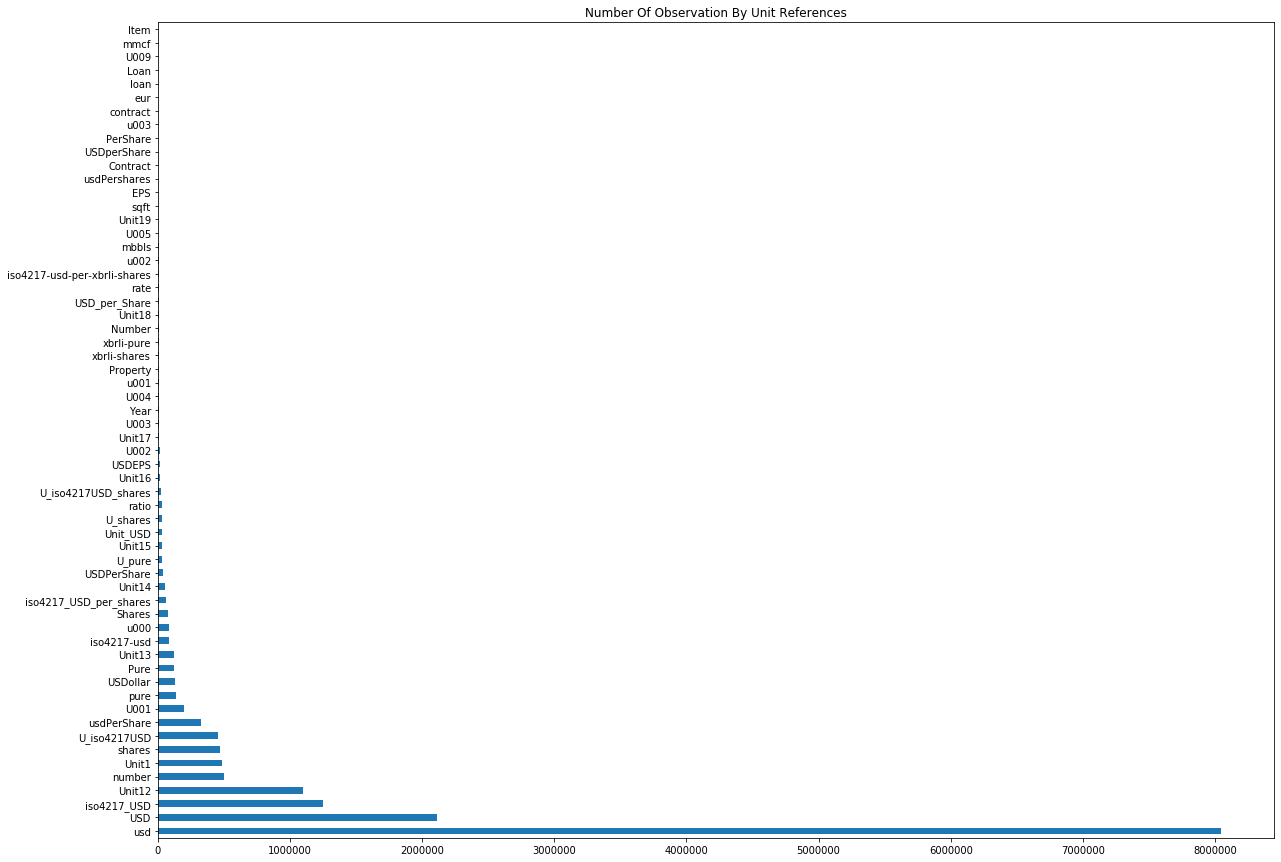

In [10]:
df['unit_ref'].value_counts()[:60].plot.barh(
    figsize=(20, 15),
    title='Number Of Observation By Unit References'
);

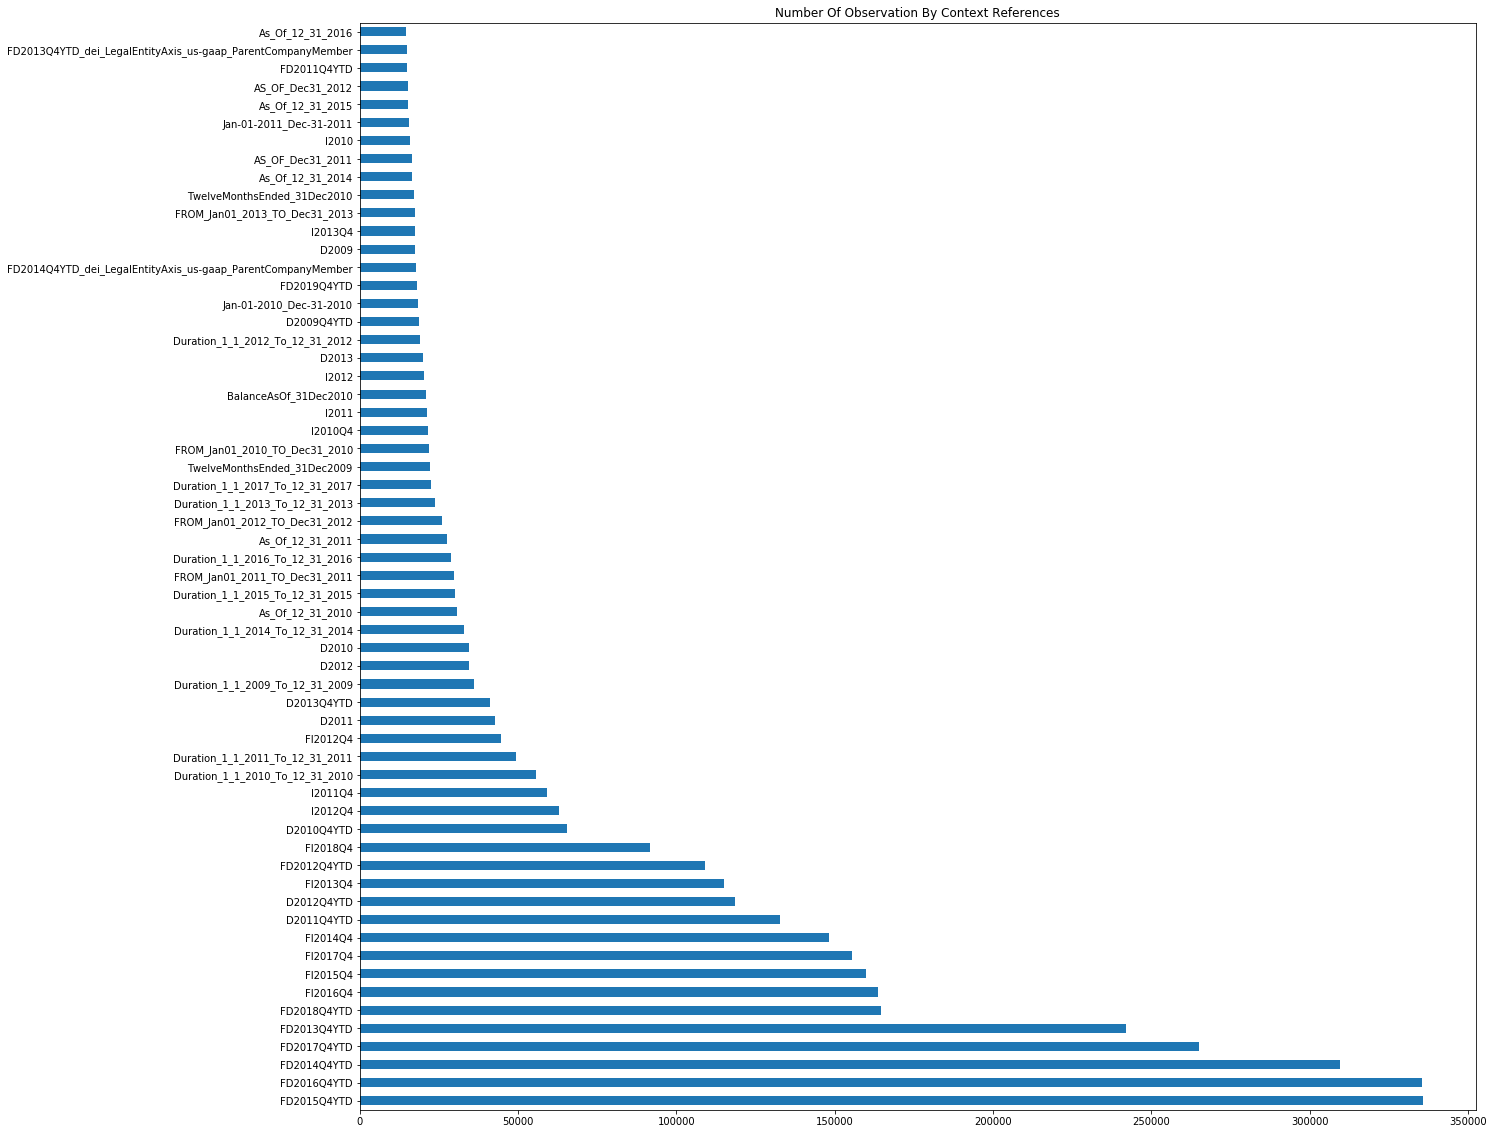

In [11]:
df['context_ref'].value_counts()[:60].plot.barh(
    figsize=(20, 20), 
    title='Number Of Observation By Context References'
);

---

In [12]:
df = df[df['value'].notnull()]
df['year'] = df['context_ref'].str.extract(
    r'^F[DI](201\d)Q4(?:YTD)?$'
)

In [13]:
df = df[df['year'].notnull()]
df.drop_duplicates(('security', 'name', 'year'), inplace=True)

---

In [14]:
df['security_year'] = list(zip(df['security'], df['year']))

In [15]:
df = pd.pivot(df, index='security_year', columns='name', values='value')
df.dropna(axis=1, how='all', inplace=True)
df['security'] = [security for security, year in df.index]
df['year'] = [year for security, year in df.index]
df.reset_index(drop=True, inplace=True)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5557 entries, 0 to 5556
Columns: 74703 entries, A A C Note Securedby R M B S Securities Value Not Less Than to year
dtypes: object(74703)
memory usage: 3.1+ GB


---

In [17]:
df = df[df.isnull().sum().sort_values()[:50].index]

In [18]:
str_features = [
    'Current Fiscal Year End Date',
    'Document Fiscal Period Focus',
    'Document Type',
    'Entity Central Index Key',
    'Entity Current Reporting Status',
    'Entity Filer Category',
    'Entity Voluntary Filers',
    'Entity Well Known Seasoned Issuer',
    'security'
]

In [19]:
float_features = [f for f in df.columns if f not in str_features and f != 'Document Period End Date']

In [20]:
df[float_features] = df[float_features].fillna(0).astype(float)
df['Document Period End Date'] = pd.to_datetime(df['Document Period End Date'])

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5557 entries, 0 to 5556
Data columns (total 50 columns):
 #   Column                                                                            Non-Null Count  Dtype         
---  ------                                                                            --------------  -----         
 0   year                                                                              5557 non-null   float64       
 1   security                                                                          5557 non-null   object        
 2   Cash And Cash Equivalents At Carrying Value                                       5557 non-null   float64       
 3   Income Tax Expense Benefit                                                        5557 non-null   float64       
 4   Stockholders Equity                                                               5557 non-null   float64       
 5   Unrecognized Tax Benefits                                     

---

In [22]:
df.isnull().sum(1).value_counts()

0    3439
9    2117
8       1
dtype: int64

In [23]:
df = df[df.isnull().sum(1) == 0]

---

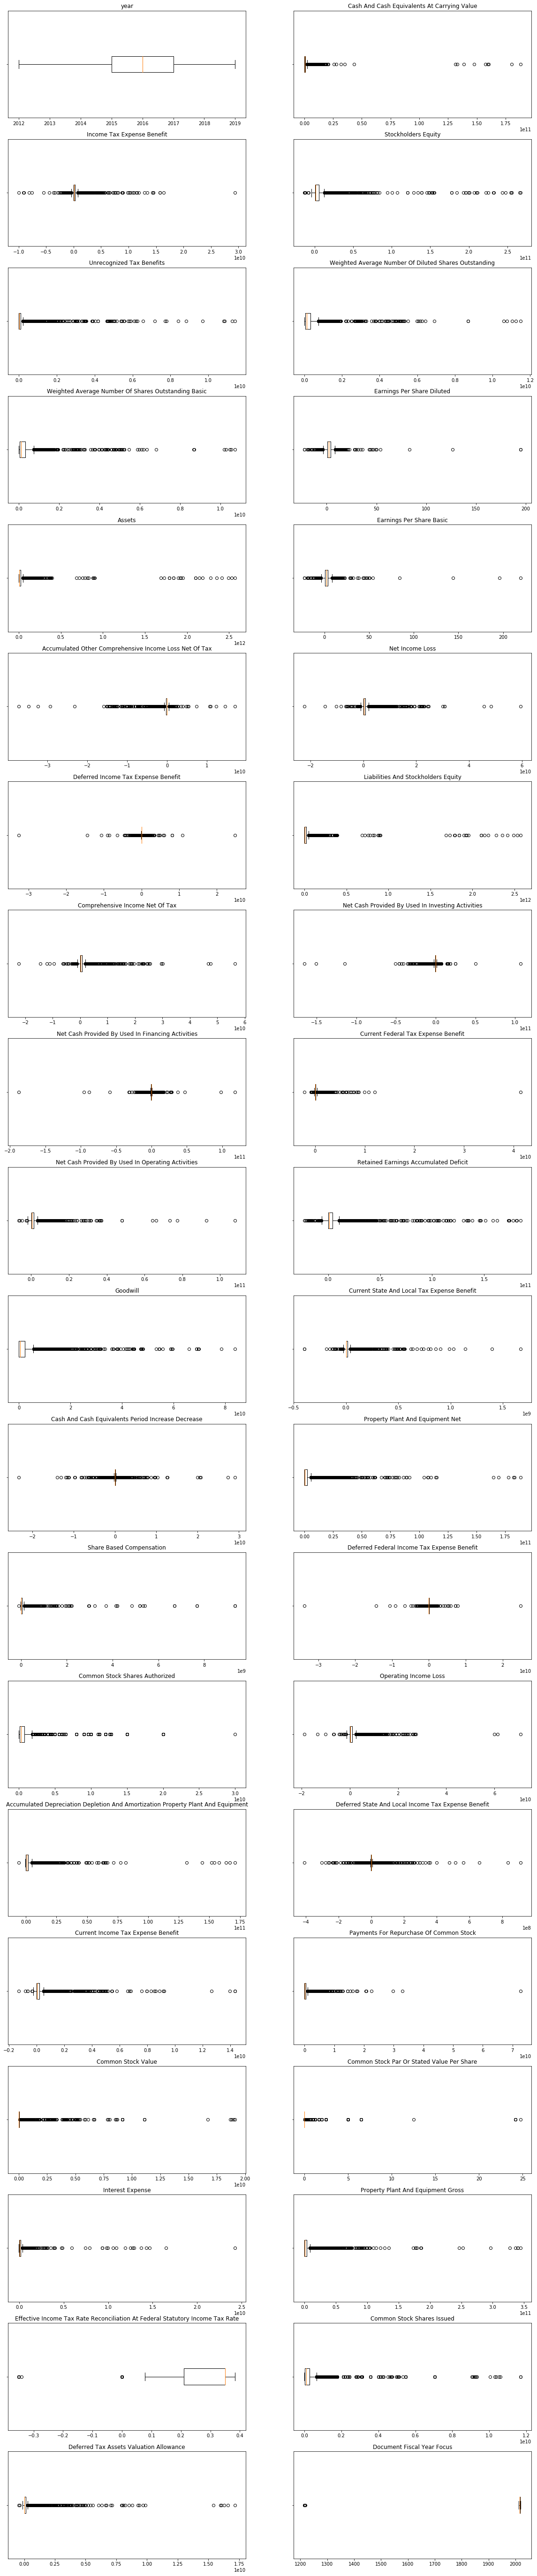

In [24]:
ncols = 2
nrows = len(float_features) // ncols
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 5 * nrows))
ax = ax.ravel() # Ravel turns a matrix into a vector, which is easier to iterate
for n, f in enumerate(float_features):
    ax[n].boxplot(df[f], vert=False)
    ax[n].set_title(f)
    ax[n].set_yticklabels([])

In [25]:
df.drop(
    columns='Document Fiscal Year Focus',
    inplace=True
)

---

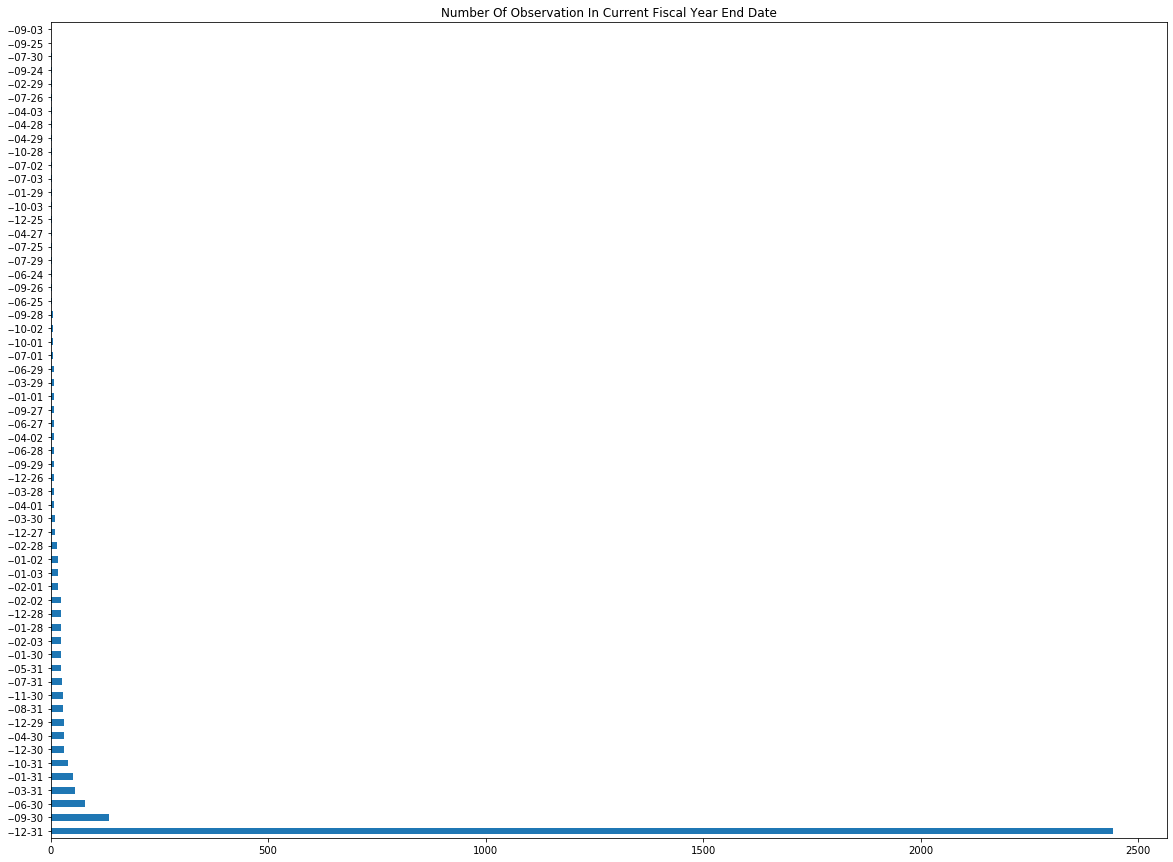

In [26]:
df['Current Fiscal Year End Date'].value_counts()[:60].plot.barh(
    figsize=(20, 15),
    title='Number Of Observation In Current Fiscal Year End Date'
);

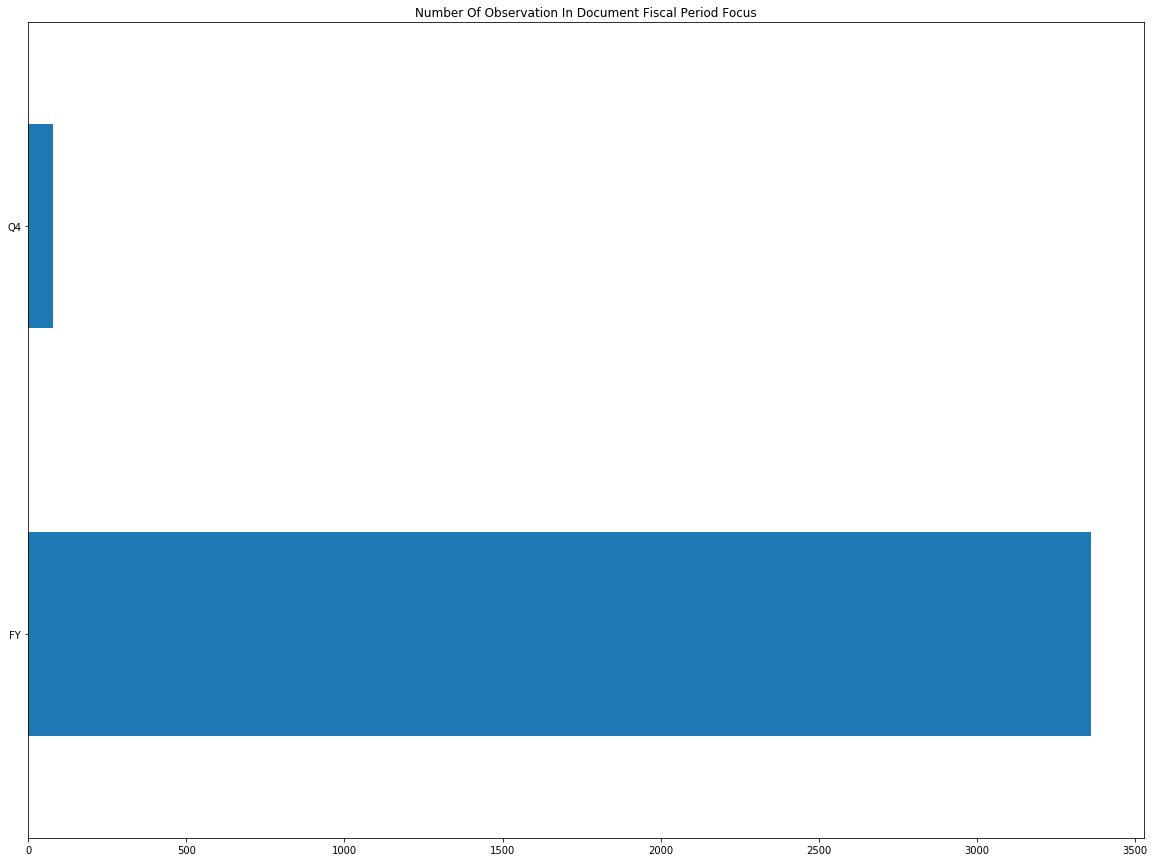

In [27]:
df['Document Fiscal Period Focus'].value_counts().plot.barh(
    figsize=(20, 15),
    title='Number Of Observation In Document Fiscal Period Focus'
);

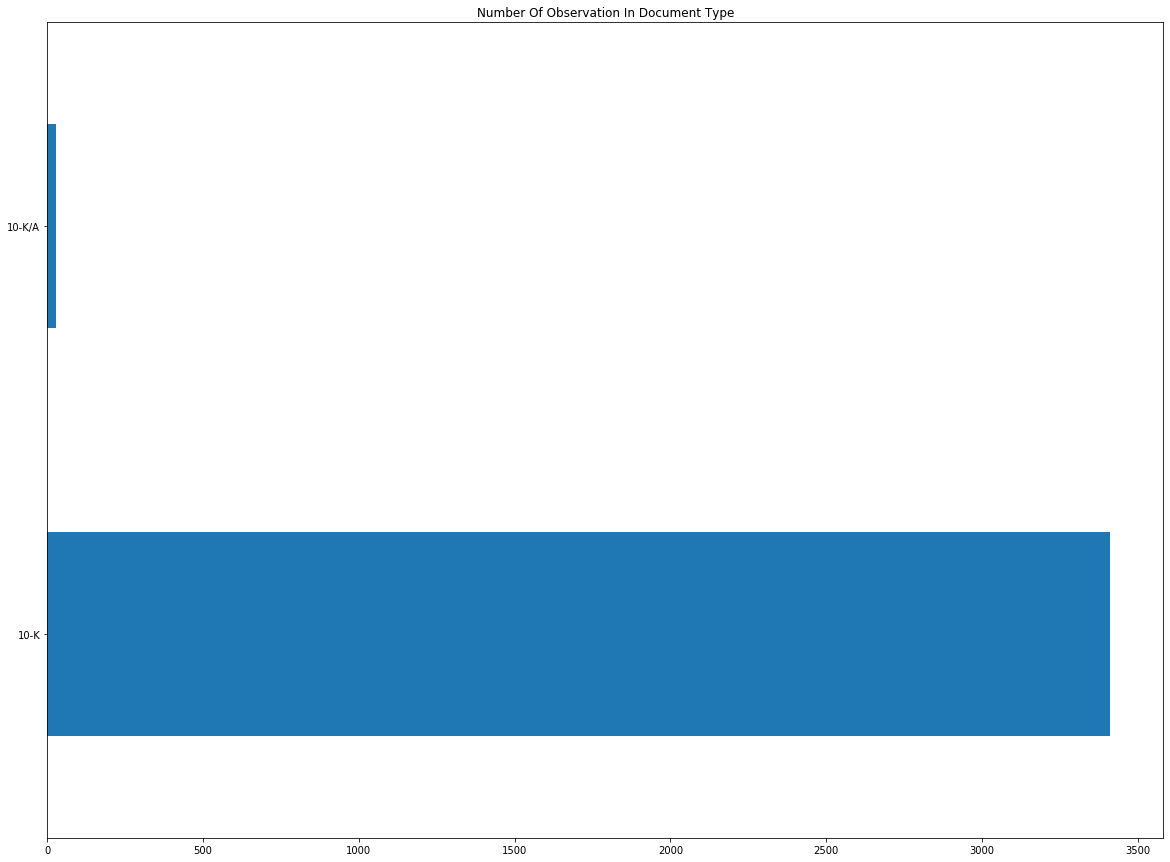

In [28]:
df['Document Type'].value_counts().plot.barh(
    figsize=(20, 15),
    title='Number Of Observation In Document Type'
);

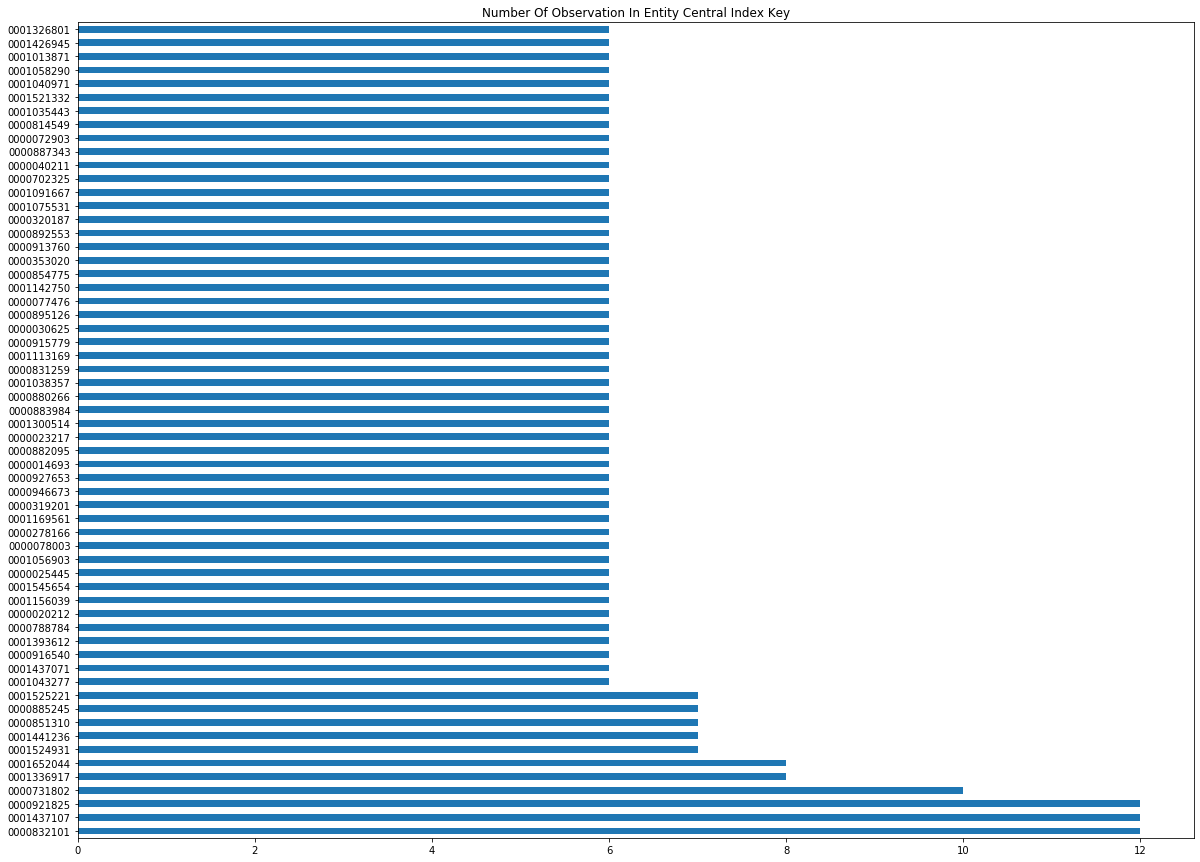

In [29]:
df['Entity Central Index Key'].value_counts()[:60].plot.barh(
    figsize=(20, 15),
    title='Number Of Observation In Entity Central Index Key'
);

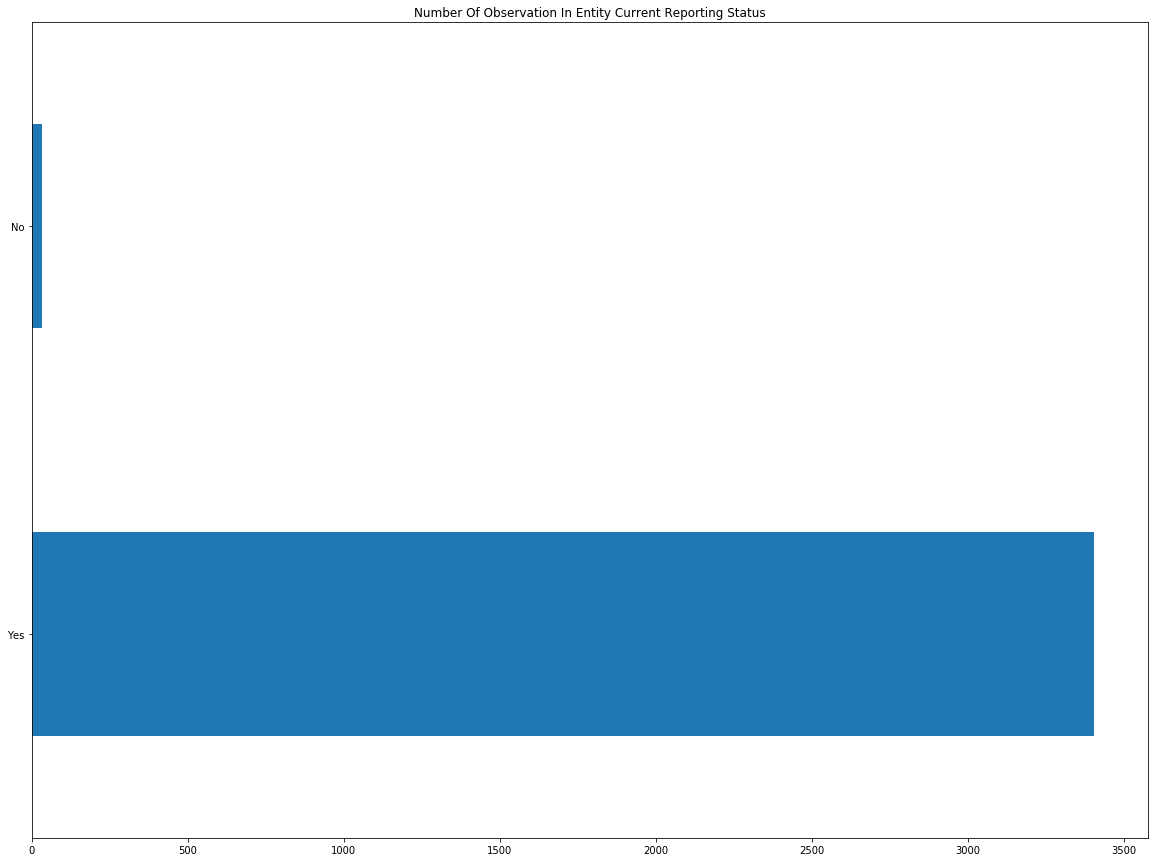

In [30]:
df['Entity Current Reporting Status'].value_counts().plot.barh(
    figsize=(20, 15),
    title='Number Of Observation In Entity Current Reporting Status'
);

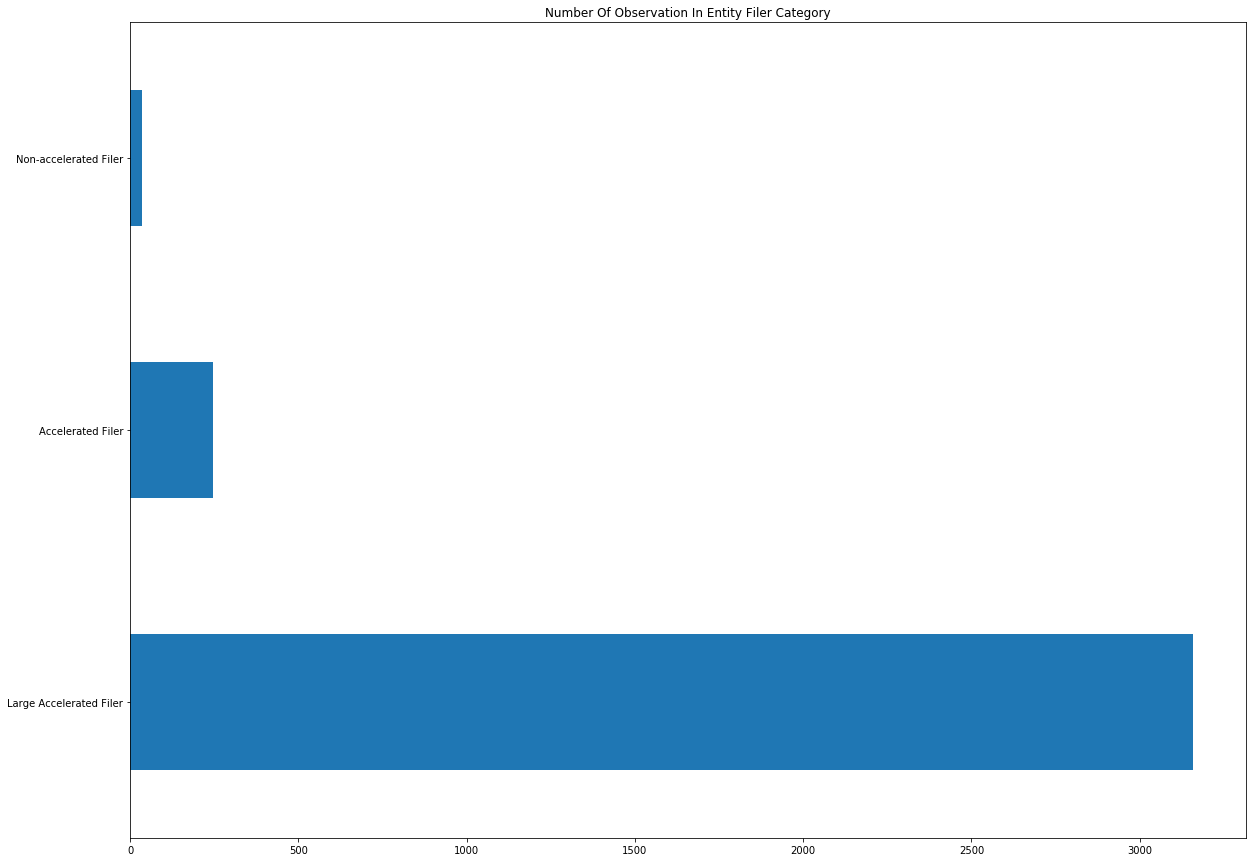

In [31]:
df['Entity Filer Category'].value_counts().plot.barh(
    figsize=(20, 15),
    title='Number Of Observation In Entity Filer Category'
);

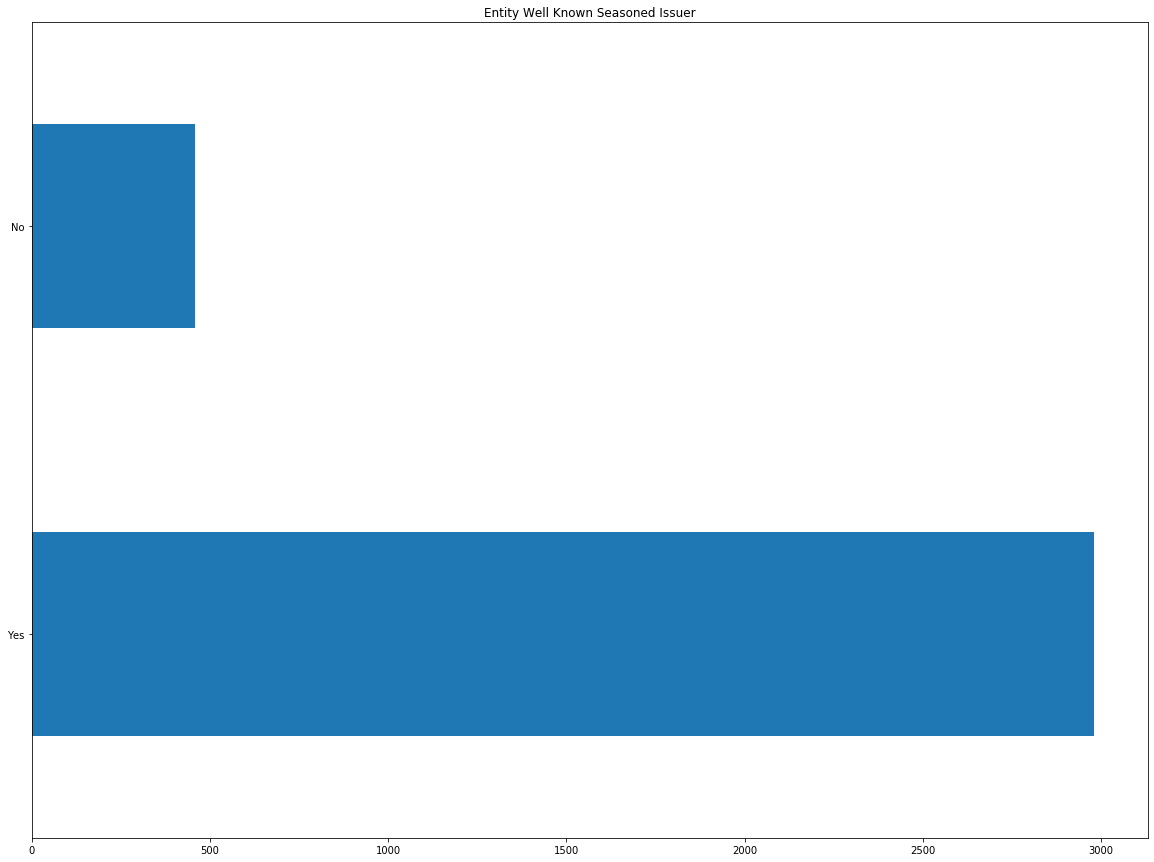

In [32]:
df['Entity Well Known Seasoned Issuer'].value_counts().plot.barh(
    figsize=(20, 15),
    title='Entity Well Known Seasoned Issuer'
);

In [33]:
df.drop(
    columns=['Current Fiscal Year End Date', 'Entity Central Index Key'],
    inplace=True
)

---

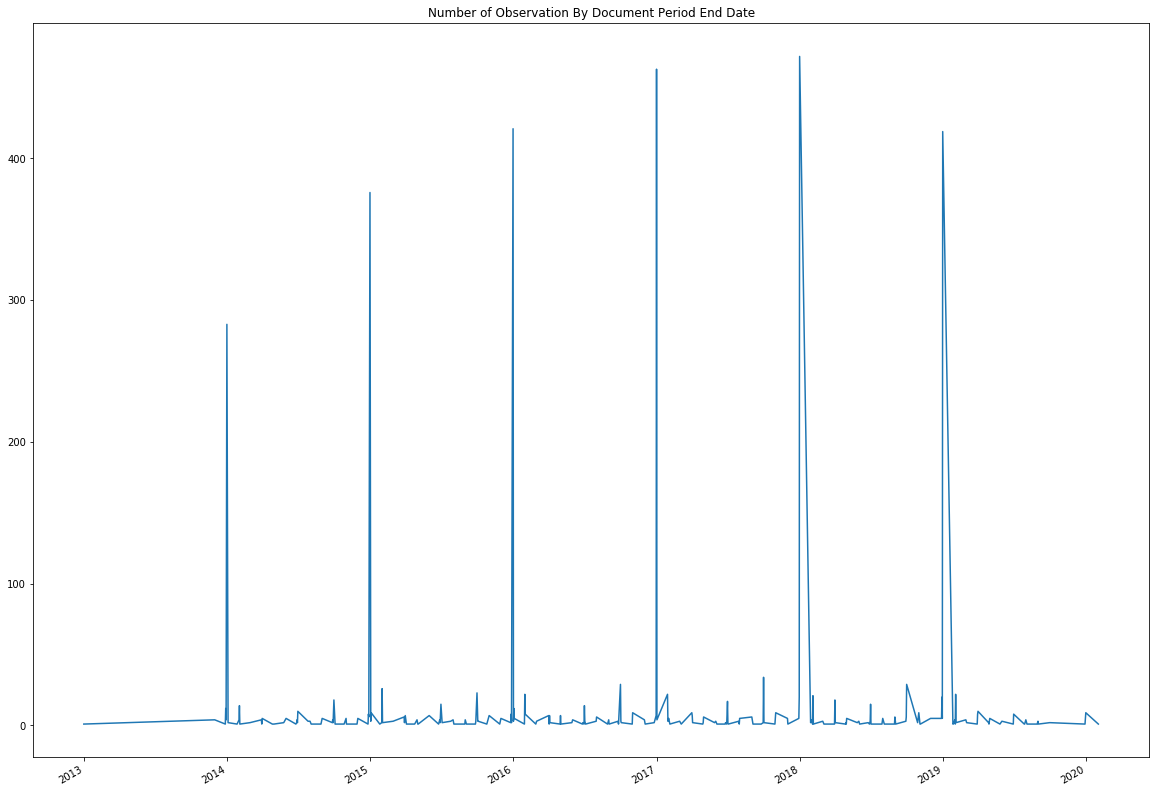

In [34]:
df['Document Period End Date'].value_counts().plot(
    figsize=(20, 15), 
    title='Number of Observation By Document Period End Date'
);

---

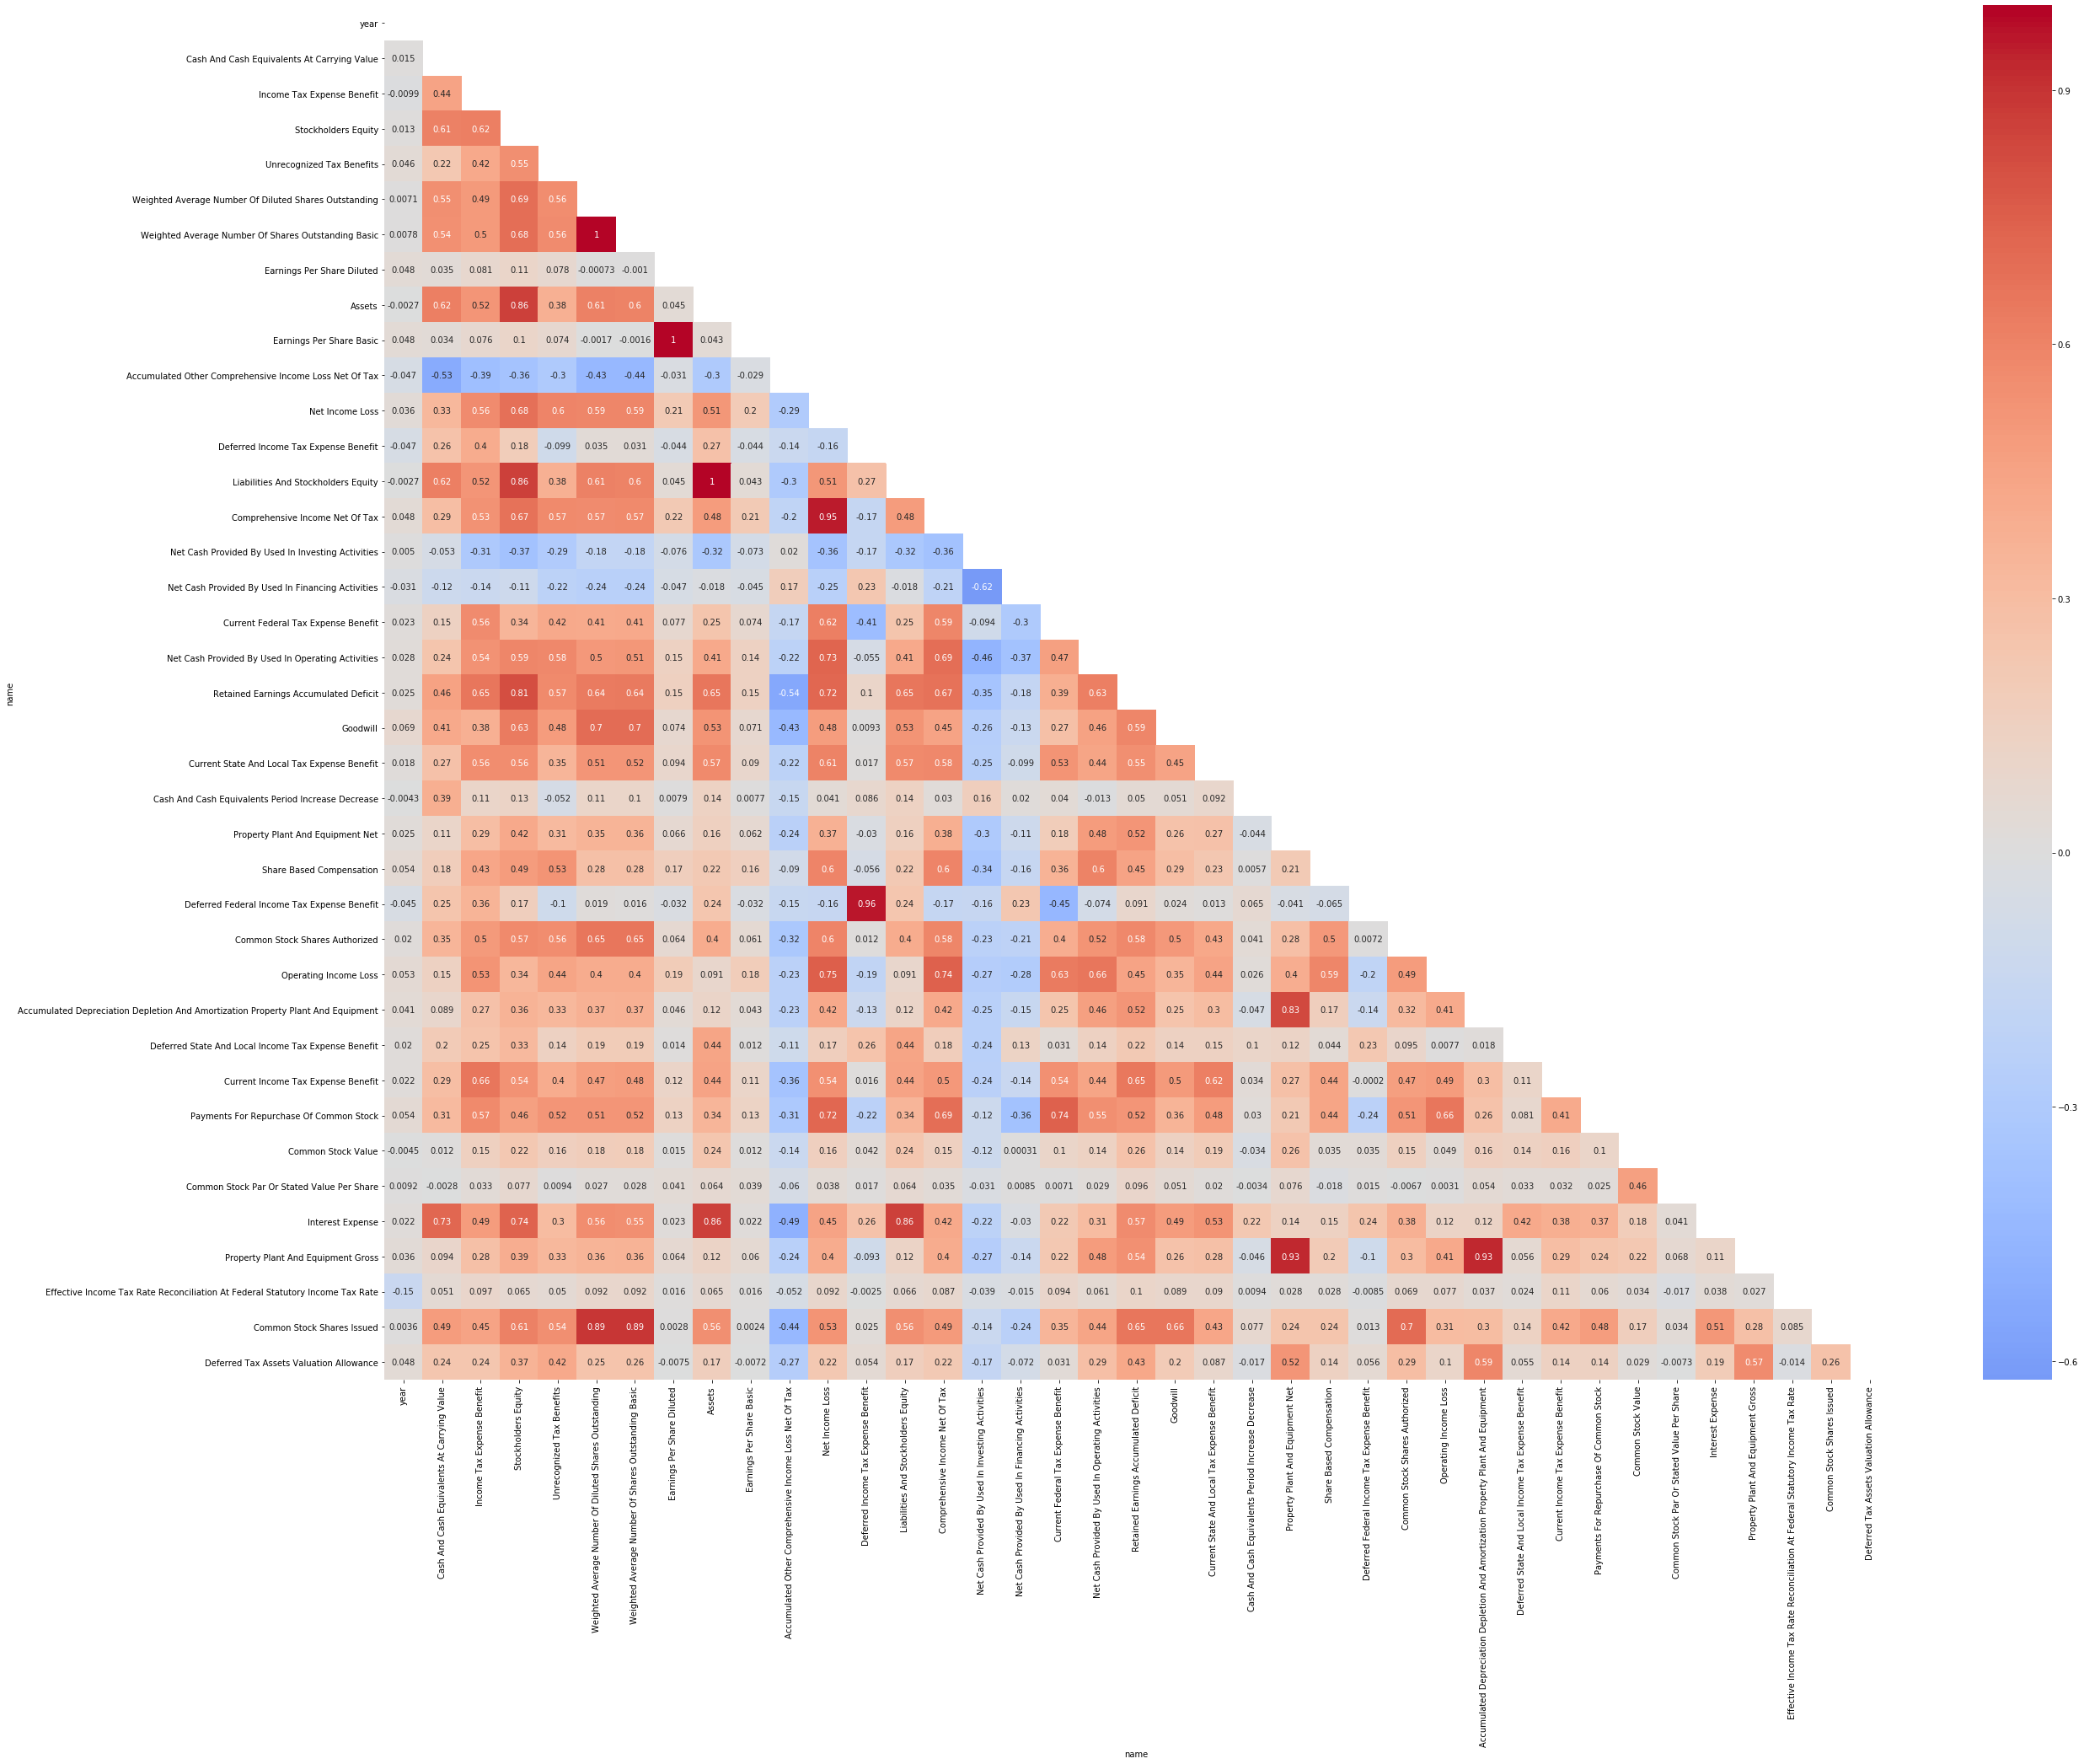

In [35]:
df_corr = df.corr()
mask = np.zeros_like(df_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(40, 30))
sns.heatmap(df_corr,
            cmap='coolwarm',
            center=0,
            annot=True,
            mask=mask);

In [36]:
df.drop(
    columns=[
        'Earnings Per Share Diluted',
        'Liabilities And Stockholders Equity',
        'Weighted Average Number Of Diluted Shares Outstanding'
    ],
    inplace=True
)

---

In [37]:
df.to_csv('../data/clean.csv', index=False)